In [ ]:
import sys

sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import stats
from scipy.stats import pearsonr
import seaborn as sns
from statannotations.Annotator import Annotator
from tqdm import tqdm

from src.utils import create_total_df

mpl.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "Times New Roman"
sns.set(font_scale=0.8)

In [9]:
def data_binning(df: pd.DataFrame, target_labels: list):
    thresh = np.arange(0, 0.8, 0.1)
    thresh = np.append(thresh, 1.0)
    bin_dic = {}
    tick_names = []
    violin_data_dic = {label: [] for label in target_labels}
    for i in range(len(thresh) - 1):
        upper_th = thresh[i + 1]
        lower_th = thresh[i]
        tmp_df = df[(df["cos_sim"] > lower_th) & (df["cos_sim"] < upper_th)]
        for l in target_labels:
            violin_data_dic[l].append(tmp_df[l].values)
        tmp_dic = tmp_df.describe().loc["mean", target_labels]
        tmp_dic["count"] = tmp_df.describe().loc["count"].values[0]
        bin_dic[f"{lower_th:.1f}-{upper_th:.1f}"] = tmp_dic
        tick_names.append(f"{lower_th:.1f}-{upper_th:.1f}")
    tick_names.append("All")
    bin_dic["All"] = dict(df.describe().loc["mean", target_labels], count=len(df))
    bin_df = pd.DataFrame(bin_dic).T
    return (violin_data_dic, tick_names, bin_df)


def concat_df(tot_df: pd.DataFrame, ribo: pd.DataFrame, rna: pd.DataFrame):
    remover = lambda x: x.split(".")[0]  # noqa E738
    ribo["ENST_ID"] = ribo["transcript_id"].apply(remover)
    rna["ENST_ID"] = rna["transcript_id"].apply(remover)
    df_concat = pd.merge(tot_df, ribo, on="ENST_ID", how="inner")
    df_concat = pd.merge(df_concat, rna, on="ENST_ID", how="inner")
    df_concat = df_concat[(df_concat["cds_len"] != 0) & (df_concat["TPM_rna"] != 0)]
    df_concat["TE"] = df_concat["TPM_ribo"] / df_concat["TPM_rna"]

    return df_concat


def boxplot_targets_topbin(
    df: pd.DataFrame,
    all_targets: list,
    violin_data_dic: dict,
    tick_names: list,
    save_name=None,
    values_name="values",
    tick_name="tick_name",
    target_name="target",
    figsize=(4, 6),
):
    _, ax = plt.subplots(1, 1, figsize=figsize)

    plot_data_df = {values_name: [], tick_name: [], target_name: []}
    stats_pairs = []
    pvalues = []

    for target in all_targets:
        all_df = df[~((df["cos_sim"] > 0.7) & (df["cos_sim"] < 1))]
        ## only take highest bin amd all_data
        values = np.concatenate([violin_data_dic[target][-1], all_df[target].values])
        plot_data_df[values_name].extend(values)
        plot_data_df[tick_name].extend(
            np.concatenate(
                [
                    np.repeat(tick_names[-2], len(violin_data_dic[target][-1])),
                    np.repeat("All", len(all_df)),
                ]
            )
        )
        plot_data_df[target_name].extend(np.repeat(target, len(values)))

        ## stats info
        stats_pairs.append(((target, tick_names[-2]), (target, tick_names[-1])))
        stats_x = violin_data_dic[target][-1]
        stats_y = all_df[target].values
        pvalues.append(stats.mannwhitneyu(stats_x, stats_y)[-1])
    data_df = pd.DataFrame(plot_data_df)

    plot_params = {
        "data": data_df,
        "x": target_name,
        "y": values_name,
        "hue": tick_name,
        "showfliers": False,
    }
    sns.boxplot(**plot_params)

    annotator = Annotator(ax, stats_pairs, **plot_params)
    annotator.set_pvalues(pvalues)
    annotator.annotate()

    plt.setp(ax.get_xticklabels(), rotation=15)
    plt.tight_layout()
    plt.xlabel(None)

    if save_name:
        plt.savefig(f"./results/imgs/{save_name}")

In [15]:
seq_df = pd.read_csv('../data/human/gencode44_utr_gene_unique_cdhit09_mfe.csv')
cl_dir = "../results/runs/contrastive_learning_10fold_rinalmo_whole_ave_seed1"

total_df_cl = create_total_df(cl_dir,seq_df)
total_df_cl=total_df_cl.drop("ENST_ID",axis=1).rename(columns={"ENST_ID_PRE":"ENST_ID"})


## Length,MFE basic features

In [16]:
targets = ["5UTR_len", "3UTR_len", "CDS_len", "total_len"]
violin_data_dic, tick_names, bin_df = data_binning(total_df_cl, target_labels=targets)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3UTR_len_0.7-1.0 vs. 3UTR_len_All: Custom statistical test, P_val:9.519e-04
5UTR_len_0.7-1.0 vs. 5UTR_len_All: Custom statistical test, P_val:1.336e-04
CDS_len_0.7-1.0 vs. CDS_len_All: Custom statistical test, P_val:8.281e-01
total_len_0.7-1.0 vs. total_len_All: Custom statistical test, P_val:4.871e-02


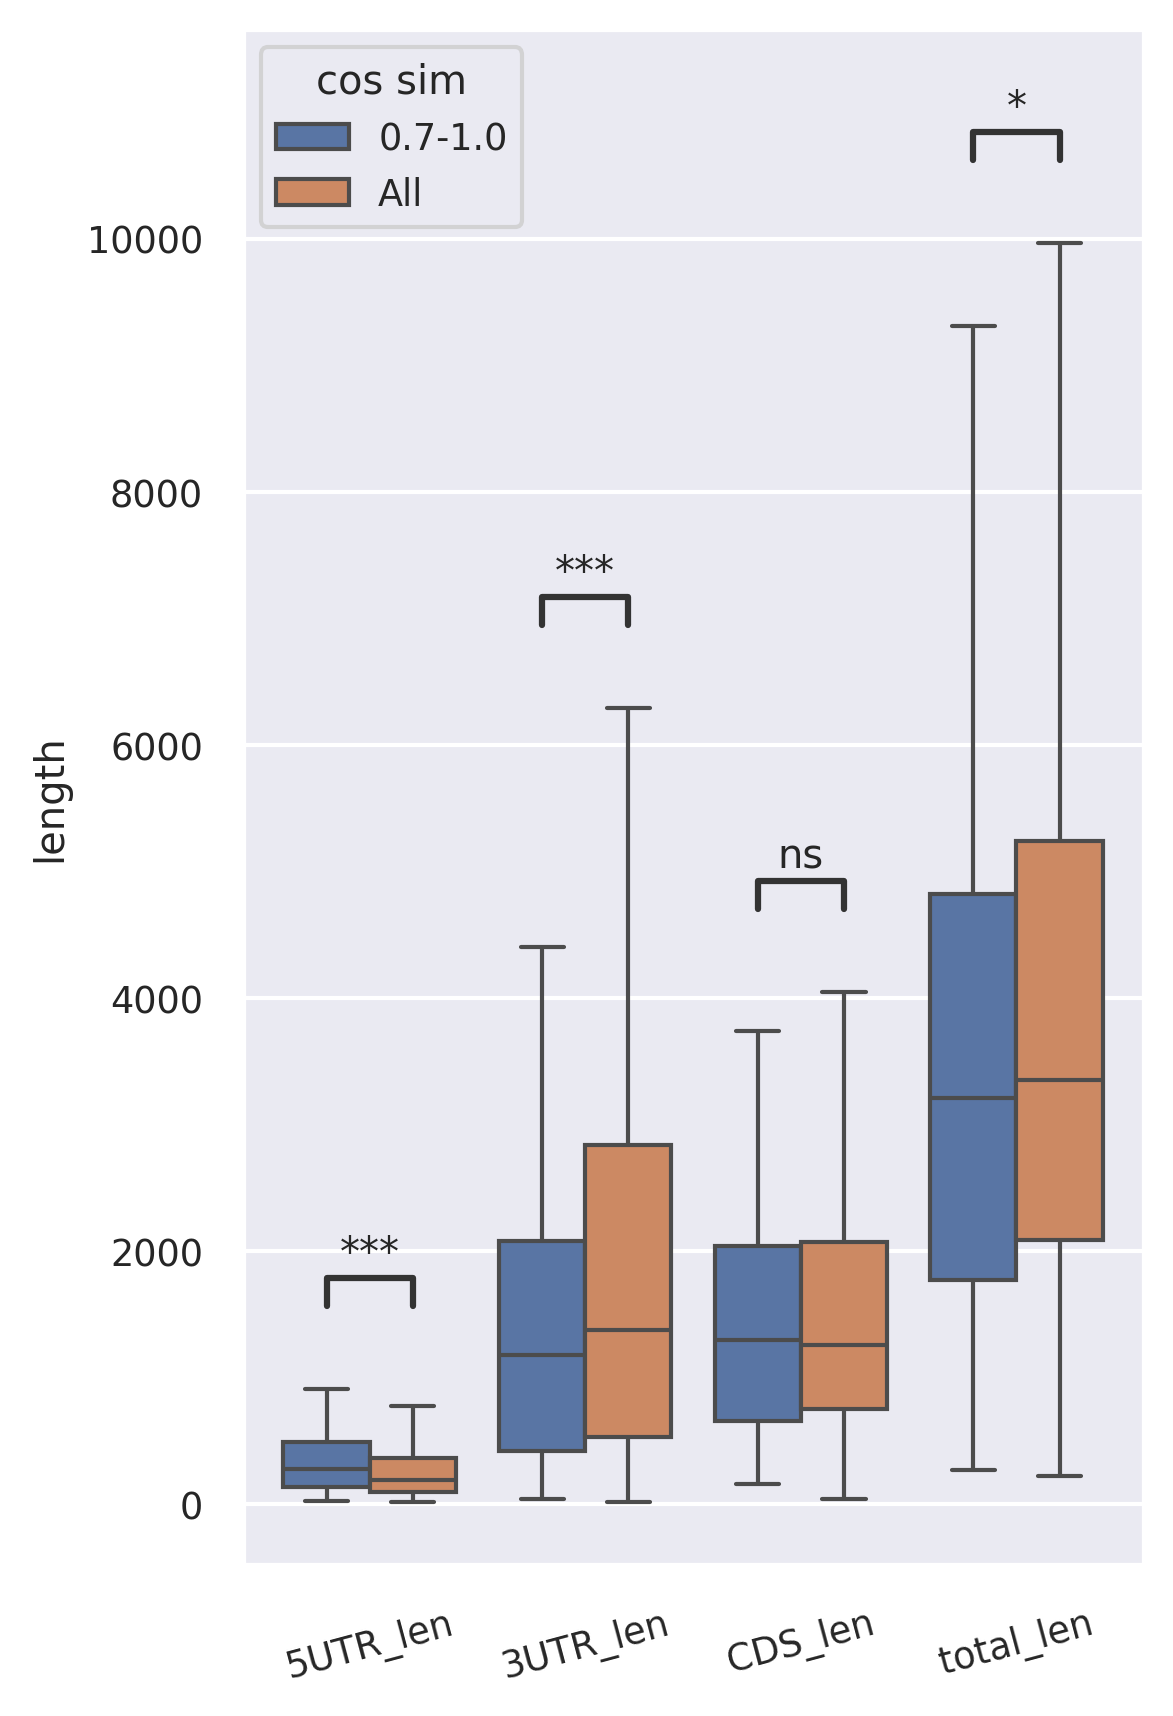

In [18]:
# Length comparison
boxplot_targets_topbin(
    total_df_cl,
    all_targets=targets,
    violin_data_dic=violin_data_dic,
    tick_names=tick_names,
    # save_name="boxplot_length",
    values_name="length",
    tick_name="cos sim",
    target_name=" ",
    figsize=(4, 6),
)

## MFE comparisonm

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

5UTR_tail_mfe_0.7-1.0 vs. 5UTR_tail_mfe_All: Custom statistical test, P_val:5.650e-03
5UTR_head_mfe_0.7-1.0 vs. 5UTR_head_mfe_All: Custom statistical test, P_val:9.021e-01
5UTR_tail_cds_mfe_0.7-1.0 vs. 5UTR_tail_cds_mfe_All: Custom statistical test, P_val:4.658e-03


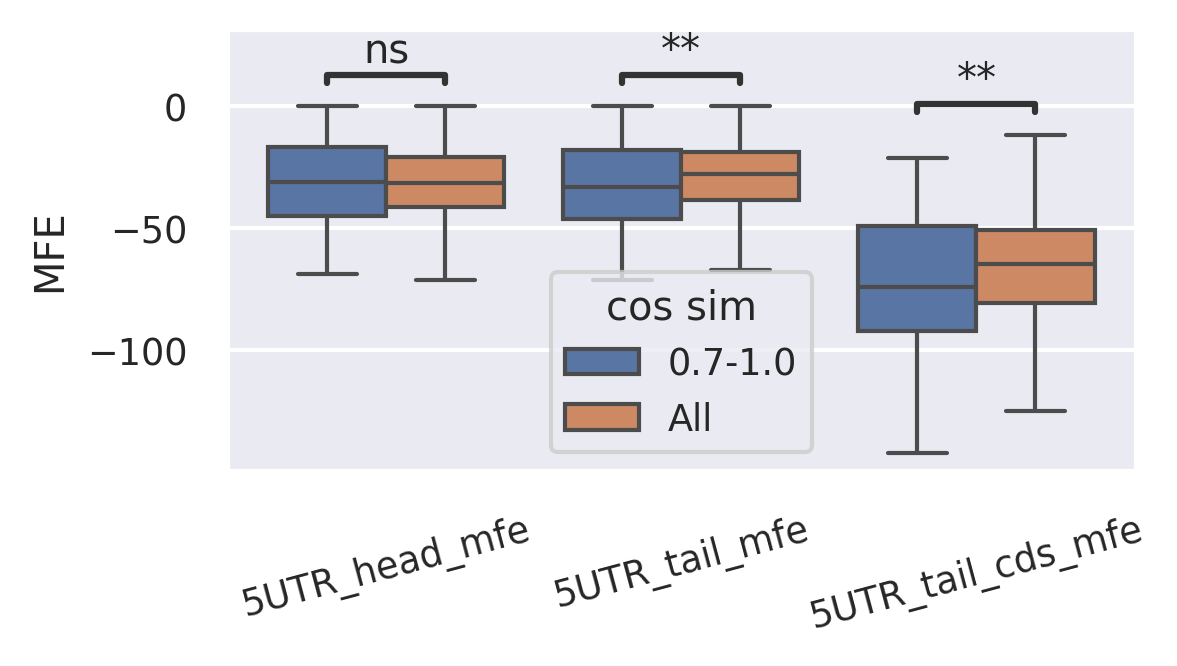

In [ ]:
# Around 5'UTR
targets = ['5UTR_head_mfe','5UTR_tail_mfe','5UTR_tail_cds_mfe']
violin_data_dic,tick_names,bin_df = data_binning(total_df_cl,target_labels=targets)

boxplot_targets_topbin(
    total_df_cl,
    all_targets=targets,
    violin_data_dic=violin_data_dic,
    tick_names=tick_names,
    #save_name="boxplot_mfe_utr5_all_in_one",
    values_name="MFE",
    tick_name="cos sim",
    target_name=" ",
    figsize=(4, 2.5),
)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3UTR_head_mfe_0.7-1.0 vs. 3UTR_head_mfe_All: Custom statistical test, P_val:1.349e-01
3UTR_head_cds_mfe_0.7-1.0 vs. 3UTR_head_cds_mfe_All: Custom statistical test, P_val:8.579e-02
3UTR_tail_mfe_0.7-1.0 vs. 3UTR_tail_mfe_All: Custom statistical test, P_val:7.652e-01


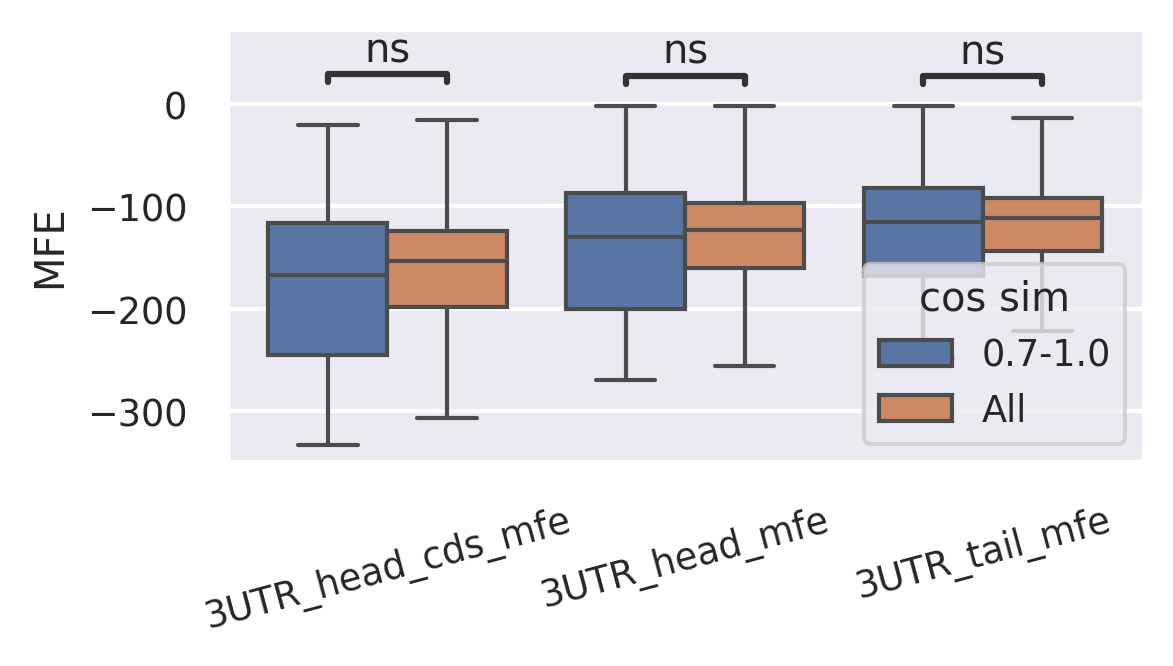

In [30]:
# Around 3'UTR
targets= ['3UTR_head_cds_mfe','3UTR_head_mfe','3UTR_tail_mfe']
violin_data_dic, tick_names, bin_df = data_binning(total_df_cl, target_labels=targets)

boxplot_targets_topbin(
    total_df_cl,
    all_targets=targets,
    violin_data_dic=violin_data_dic,
    tick_names=tick_names,
    #save_name="boxplot_mfe_utr3_all_in_one",
    values_name="MFE",
    tick_name="cos sim",
    target_name=" ",
    figsize=(4, 2.5),
)